In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import gridspec
import ipywidgets as widgets
import numpy as np
import requests
from pathlib import Path

from tqdm.notebook import tqdm

In [58]:
from dataclasses import dataclass

@dataclass
class ImageInfo:
    image_path: Path
    url: str
    img: cv.Mat|None = None

    def download(self) -> cv.Mat:
        if not self.image_path.exists():
            img_data = requests.get(self.url).content
            with open(self.image_path, 'wb') as f:
                f.write(img_data)
    
        # Opencv reads images in BGR.
        self.img = cv.imread(self.image_path)

    def rgb(self) -> cv.Mat:
        return cv.cvtColor(self.img, cv.COLOR_BGR2RGB)


class ImageCache:
    def __init__(self, base_path: str = './img/002-images'):
        self._base_path = Path(base_path)
        self._base_path.mkdir(parents=True, exist_ok=True)
        
        self._cache: dict[str, ImageInfo] = {
            'pluto': ImageInfo( # https://plus.nasa.gov/video/the-year-of-pluto/
                image_path=self._base_path / 'pluto.png',
                url='https://plus.nasa.gov/wp-content/uploads/2023/08/nasaplus_14_TheYearofPlutoHorizontal-Hero-16_9-Without-Title.png?w=1024',
            ),
            'coleman': ImageInfo( # https://www.youtube.com/watch?v=IRDpW7QOyGw
                image_path=self._base_path / 'coleman.jpg',
                url='https://i.ytimg.com/vi/IRDpW7QOyGw/hqdefault.jpg?sqp=-oaymwEmCOADEOgC8quKqQMa8AEB-AH-BIAC4AOKAgwIABABGFsgWyhbMA8=&rs=AOn4CLDD0L8mY-E9TAjvJlvGx-TXoFU-UQ'
            ),
        }
        for _, img in tqdm(self._cache.items(), desc="Downloading images"):
            img.download()

    def images(self):
        """Return all the image names registered."""
        return self._cache.keys()

    def __getitem__(self, img_name: str) -> ImageInfo:
        """Allow dictionary-like access to loaded images."""
        if img_name not in self._cache:
            self.load_img(img_name)
        return self._cache[img_name]


CACHE = ImageCache()

In [3]:
CACHE.images()

dict_keys(['pluto'])

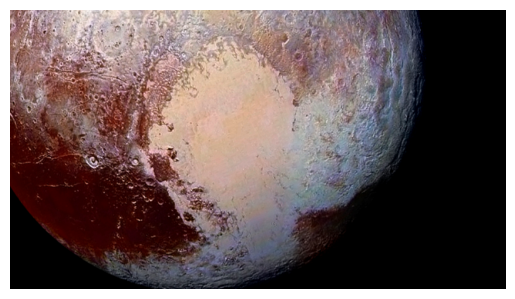

In [4]:
plt.imshow(CACHE['pluto'].rgb())
plt.axis('off')    
plt.show()

# Gaussian Noise

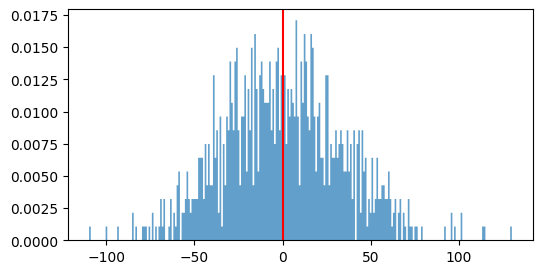

In [5]:
# See
# https://github.com/seafoodfry/numerical-analysis/blob/main/stats/basics/01-continuous-distributions.ipynb

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

noise_sigma = 35

ax.axvline(x=0, color='r')

# NOTE: don't center the noise around a value like 256//2.
# If you do, even a small variance will wash everything out because you are just adding 123(-ish)
# to the entire picture.
r = np.random.normal(0, noise_sigma, (1_000))
ax.hist(r, bins=256, density=True, histtype="stepfilled", alpha=0.7)

plt.show()

In [6]:
_example_noise = np.random.normal(50, 10, (3, 2))
_example_noise

array([[56.79826259, 56.94878281],
       [51.54270312, 63.69277786],
       [42.0008318 , 42.46481052]])

In [7]:
_example_noise.astype(np.uint8)

array([[56, 56],
       [51, 63],
       [42, 42]], dtype=uint8)

In [8]:
# Simple gaussian noise addition: the mapping is rough since noise is instantly mapped
# to uint8.
#
#def img_with_gaussian_noise(image: np.ndarray, noise_sigma: int = 5) -> np.ndarray:
#    noise = np.random.normal(0, noise_sigma, image.shape).astype(np.uint8)
#    return cv.add(image, noise)


def add_gaussian_noise(image: np.ndarray, /, mean : float = 0, sigma: float = 25):
    # Make sure image is float type with values between [0, 1].
    # Normalization can be very useful for other image processing and ML tasks.
    normalized_img = image.astype(np.float64) / 255.0
    
    # Generate Gaussian noise.
    mean = 0
    noise = np.random.normal(mean, sigma/255, normalized_img.shape)
    
    # Add noise to image.
    noisy_image = normalized_img + noise
    
    # Clip the values to keep them between 0 and 1.
    noisy_image = np.clip(noisy_image, 0, 1)
    
    # Convert back to original dtype.
    return (noisy_image * 255).astype(np.uint8)

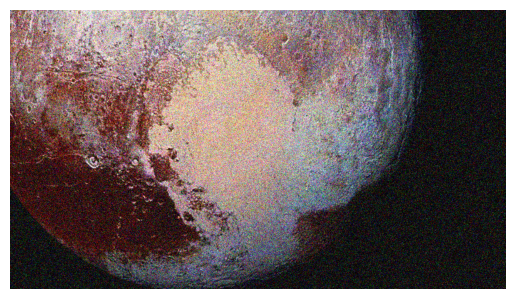

In [9]:
noisy_pluto = add_gaussian_noise(CACHE['pluto'].img, sigma=50)
img_rgb = cv.cvtColor(noisy_pluto, cv.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')    
plt.show()

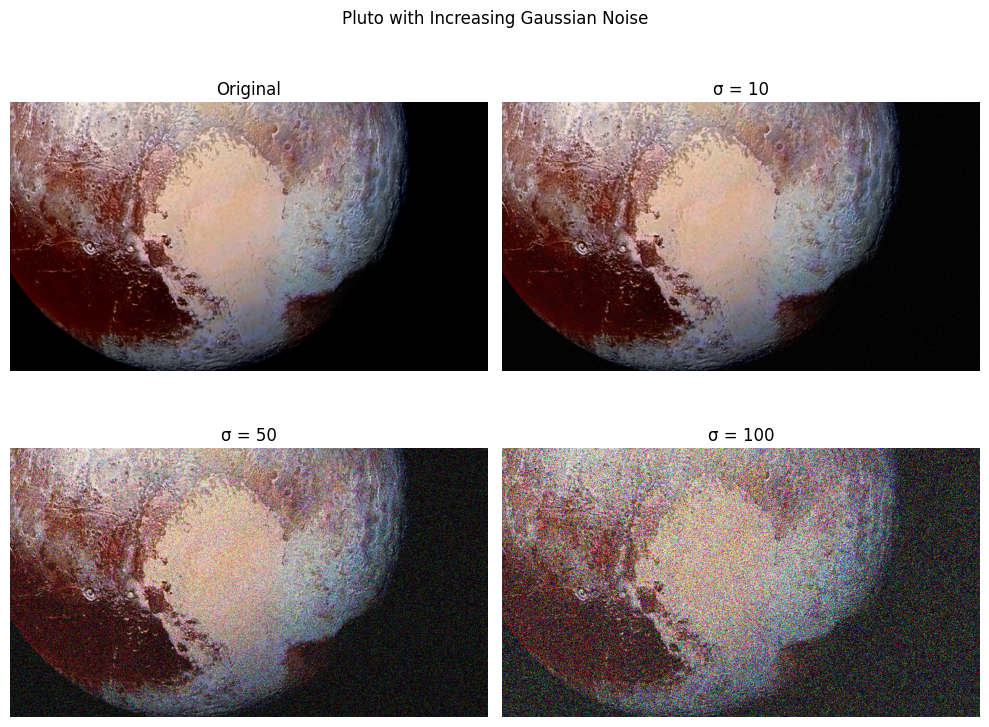

In [10]:
# Create a figure with 2x2 subplots.
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Pluto with Increasing Gaussian Noise', fontsize=12)

# Original image.
axes[0, 0].imshow(CACHE['pluto'].rgb())
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

# Add noise with increasing sigma values.
noise_levels = [10, 50, 100]
positions = [(0, 1), (1, 0), (1, 1)]  # Row, column positions for the noisy images.

for (row, col), sigma in zip(positions, noise_levels):
    noisy_img = add_gaussian_noise(CACHE['pluto'].img, sigma=sigma)
    rgb_img = cv.cvtColor(noisy_img, cv.COLOR_BGR2RGB)
    
    axes[row, col].imshow(rgb_img)
    axes[row, col].set_title(f'σ = {sigma}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [11]:
def plot_histograms(image, ax):
    """Plot RGB histograms for the given image"""
    colors = ('red', 'green', 'blue')
    ax.clear()
    
    for i, color in enumerate(colors):
        # Calculate histogram for this channel.
        hist = cv.calcHist([image], [i], None, [256], [0, 256])
        ax.plot(hist, color=color, alpha=0.7, label=f'{color} channel')
    
    ax.set_xlim([0, 256])
    #ax.set_title('RGB Histograms of Selected Region')
    ax.set_xlabel('Pixel Value')
    ax.set_ylabel('Count')
    #ax.legend()
    ax.grid(True, alpha=0.2)

In [12]:
%matplotlib widget

In [13]:
#%matplotlib inline

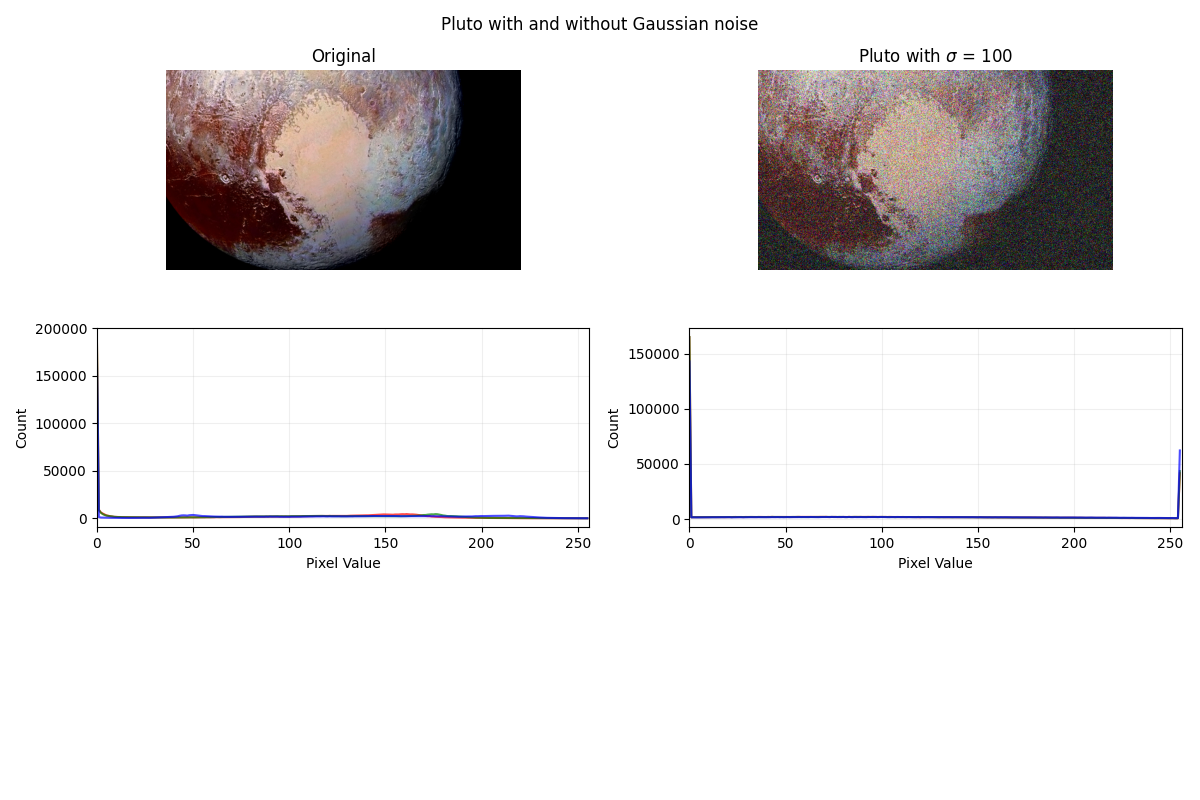

In [14]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Pluto with and without Gaussian noise', fontsize=12)

# Create grid specification with 3 rows and 2 columns.
gs = gridspec.GridSpec(3, 2, figure=fig)

# Add the subplots
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column.
ax2 = fig.add_subplot(gs[0, 1])  # First row, second column.
ax3 = fig.add_subplot(gs[1, 0])  # Second row, first column.
ax4 = fig.add_subplot(gs[1, 1])  # Second row, second column.

noisy_pluto = add_gaussian_noise(CACHE['pluto'].img, sigma=100)
img_rgb = cv.cvtColor(noisy_pluto, cv.COLOR_BGR2RGB)

# Original image.
ax1.imshow(CACHE['pluto'].rgb())
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(img_rgb)
ax2.axis('off')
ax2.set_title(r'Pluto with $\sigma$ = 100')

plot_histograms(CACHE['pluto'].img, ax3)
plot_histograms(noisy_pluto, ax4)

plt.tight_layout()
plt.show()

In [15]:
plt.close('all')

In [16]:
%matplotlib inline

# Filtering

> As in one-dimensional signals, images also can be filtered with various low-pass filters (LPF),
> high-pass filters (HPF), etc. LPF helps in removing noise, blurring images, etc.
> HPF filters help in finding edges in images.

> Image blurring is achieved by convolving the image with a low-pass filter kernel.
> It is useful for removing noise. It actually removes high frequency content (eg: noise, edges)
> from the image. So edges are blurred a little bit in this operation (there are also blurring
> techniques which don't blur the edges).

## References

- [opencv: smoothing images](https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html)
- [OpenCV Smoothing and Blurring](https://pyimagesearch.com/2021/04/28/opencv-smoothing-and-blurring/)

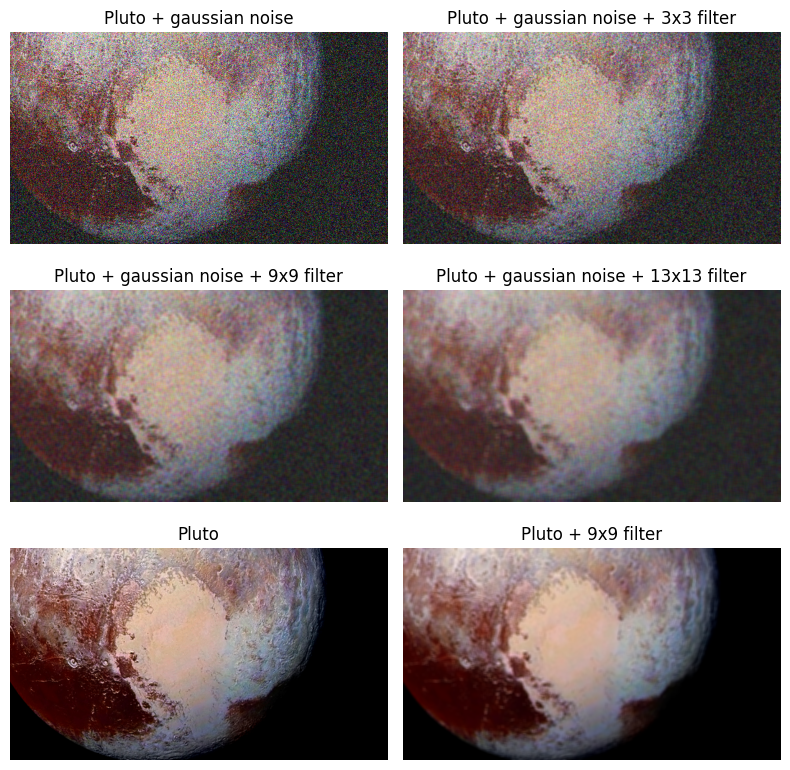

In [17]:
fig = plt.figure(figsize=(8, 8))

# Create grid specification with 3 rows and 2 columns.
gs = gridspec.GridSpec(3, 2, figure=fig)

# Add the subplots
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column.
ax2 = fig.add_subplot(gs[0, 1])  # First row, second column.
ax3 = fig.add_subplot(gs[1, 0])  # Second row, first column.
ax4 = fig.add_subplot(gs[1, 1])  # Second row, second column.
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])


noisy_pluto = add_gaussian_noise(CACHE['pluto'].img, sigma=100)
noisy_pluto_rgb = cv.cvtColor(noisy_pluto, cv.COLOR_BGR2RGB)

avg_noisy_3by3 = cv.blur(noisy_pluto, (3,3))
avg_noisy_3by3_rgb = cv.cvtColor(avg_noisy_3by3, cv.COLOR_BGR2RGB)

avg_noisy_9by9 = cv.blur(noisy_pluto, (9,9))
avg_noisy_9by9_rgb = cv.cvtColor(avg_noisy_9by9, cv.COLOR_BGR2RGB)

avg_noisy_13by13 = cv.blur(noisy_pluto, (13,13))
avg_noisy_13by13_rgb = cv.cvtColor(avg_noisy_13by13, cv.COLOR_BGR2RGB)

avg_pluto = cv.blur(CACHE['pluto'].img, (9, 9))
avg_pluto_rgb = cv.cvtColor(avg_pluto, cv.COLOR_BGR2RGB)

ax1.imshow(noisy_pluto_rgb)
ax1.axis('off')
ax1.set_title('Pluto + gaussian noise')

ax2.imshow(avg_noisy_3by3_rgb)
ax2.axis('off')
ax2.set_title('Pluto + gaussian noise + 3x3 filter')

ax3.imshow(avg_noisy_9by9_rgb)
ax3.axis('off')
ax3.set_title('Pluto + gaussian noise + 9x9 filter')

ax4.imshow(avg_noisy_13by13_rgb)
ax4.axis('off')
ax4.set_title('Pluto + gaussian noise + 13x13 filter')

ax5.imshow(CACHE['pluto'].rgb())
ax5.axis('off')
ax5.set_title('Pluto')

ax6.imshow(avg_pluto_rgb)
ax6.axis('off')
ax6.set_title('Pluto + 9x9 filter')

plt.tight_layout()
plt.show()

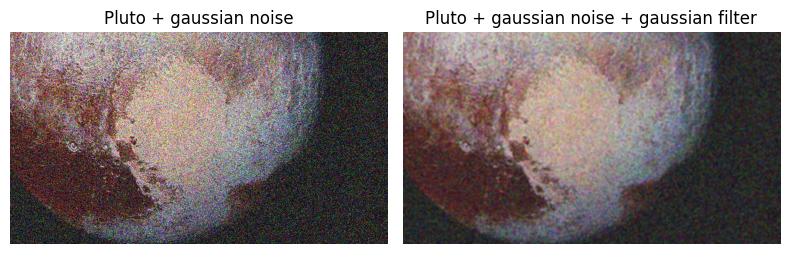

In [18]:
fig = plt.figure(figsize=(8, 5))

# Create grid specification with 3 rows and 2 columns.
gs = gridspec.GridSpec(1, 2, figure=fig)

# Add the subplots
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column.
ax2 = fig.add_subplot(gs[0, 1])  # First row, second column.


noisy_pluto = add_gaussian_noise(CACHE['pluto'].img, sigma=100)
noisy_pluto_rgb = cv.cvtColor(noisy_pluto, cv.COLOR_BGR2RGB)

gaussian_pluto = cv.GaussianBlur(noisy_pluto, (7, 7), 3, 3)
gaussian_pluto_rgb = cv.cvtColor(gaussian_pluto, cv.COLOR_BGR2RGB)


ax1.imshow(noisy_pluto_rgb)
ax1.axis('off')
ax1.set_title('Pluto + gaussian noise')

ax2.imshow(gaussian_pluto_rgb)
ax2.axis('off')
ax2.set_title('Pluto + gaussian noise + gaussian filter')

plt.tight_layout()
plt.show()

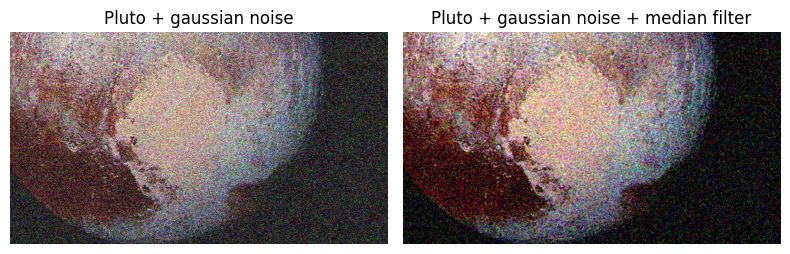

In [19]:
fig = plt.figure(figsize=(8, 5))

# Create grid specification with 3 rows and 2 columns.
gs = gridspec.GridSpec(1, 2, figure=fig)

# Add the subplots
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column.
ax2 = fig.add_subplot(gs[0, 1])  # First row, second column.


noisy_pluto = add_gaussian_noise(CACHE['pluto'].img, sigma=100)
noisy_pluto_rgb = cv.cvtColor(noisy_pluto, cv.COLOR_BGR2RGB)

median_pluto = cv.medianBlur(noisy_pluto, 3)
median_pluto_rgb = cv.cvtColor(median_pluto, cv.COLOR_BGR2RGB)


ax1.imshow(noisy_pluto_rgb)
ax1.axis('off')
ax1.set_title('Pluto + gaussian noise')

ax2.imshow(median_pluto_rgb)
ax2.axis('off')
ax2.set_title('Pluto + gaussian noise + median filter')

plt.tight_layout()
plt.show()

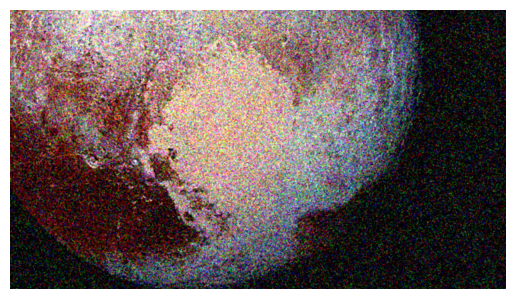

In [20]:
b, g, r = cv.split(noisy_pluto)
b = cv.medianBlur(b, 3)
g = cv.medianBlur(g, 3)
r = cv.medianBlur(r, 3)
median_pluto = cv.merge([b, g, r])
median_pluto_rgb = cv.cvtColor(median_pluto, cv.COLOR_BGR2RGB)

plt.imshow(median_pluto_rgb)
plt.axis('off')
    
plt.show()

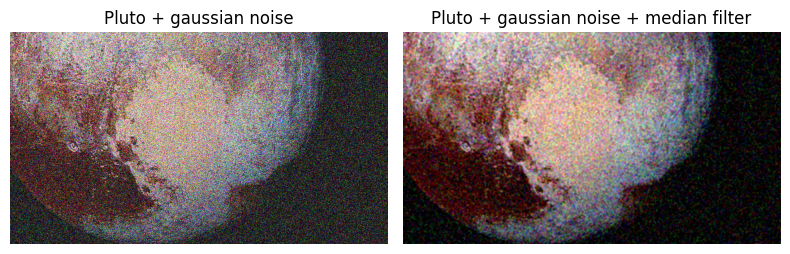

In [21]:
fig = plt.figure(figsize=(8, 5))

# Create grid specification with 3 rows and 2 columns.
gs = gridspec.GridSpec(1, 2, figure=fig)

# Add the subplots
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column.
ax2 = fig.add_subplot(gs[0, 1])  # First row, second column.


noisy_pluto = add_gaussian_noise(CACHE['pluto'].img, sigma=100)
noisy_pluto_rgb = cv.cvtColor(noisy_pluto, cv.COLOR_BGR2RGB)

median_pluto = cv.medianBlur(noisy_pluto, 5)
median_pluto_rgb = cv.cvtColor(median_pluto, cv.COLOR_BGR2RGB)


ax1.imshow(noisy_pluto_rgb)
ax1.axis('off')
ax1.set_title('Pluto + gaussian noise')

ax2.imshow(median_pluto_rgb)
ax2.axis('off')
ax2.set_title('Pluto + gaussian noise + median filter')

plt.tight_layout()
plt.show()

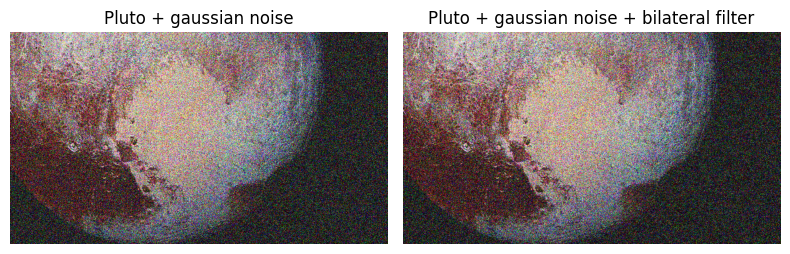

In [22]:
fig = plt.figure(figsize=(8, 5))

# Create grid specification with 1 rows and 2 columns.
gs = gridspec.GridSpec(1, 2, figure=fig)

# Add the subplots
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column.
ax2 = fig.add_subplot(gs[0, 1])  # First row, second column.


noisy_pluto = add_gaussian_noise(CACHE['pluto'].img, sigma=100)
noisy_pluto_rgb = cv.cvtColor(noisy_pluto, cv.COLOR_BGR2RGB)

bilateral_pluto = cv.bilateralFilter(noisy_pluto, 9, 41, 41)
bilateral_pluto_rgb = cv.cvtColor(bilateral_pluto, cv.COLOR_BGR2RGB)


ax1.imshow(noisy_pluto_rgb)
ax1.axis('off')
ax1.set_title('Pluto + gaussian noise')

ax2.imshow(bilateral_pluto_rgb)
ax2.axis('off')
ax2.set_title('Pluto + gaussian noise + bilateral filter')

plt.tight_layout()
plt.show()

In [39]:
# Just for reference.
_gray_img = cv.cvtColor(CACHE['pluto'].img, cv.COLOR_BGR2GRAY)
_gray_img.shape

(576, 1024)

In [53]:
def add_salt_and_pepper(image: np.ndarray, amount: float = 0.3) -> np.ndarray:
    # Create a copy of the image.
    noisy_image = image.copy()

    # Get the number of pixels to modify (half salt, half pepper).
    num_pixels = int(image.shape[0] * image.shape[1] * amount / 2)  # divide by 2 since we're doing salt and pepper separately

    # Generate random coordinates for salt noise.
    salt_y = np.random.randint(0, image.shape[0], num_pixels)
    salt_x = np.random.randint(0, image.shape[1], num_pixels)
    
    # Generate random coordinates for pepper noise.
    pepper_y = np.random.randint(0, image.shape[0], num_pixels)
    pepper_x = np.random.randint(0, image.shape[1], num_pixels)

    if len(image.shape) == 2:  # Grayscale image
        noisy_image[salt_y, salt_x] = 255
        noisy_image[pepper_y, pepper_x] = 0
    elif len(image.shape) == 3:  # Color image
        if image.shape[2] != 3:
            raise ValueError('We only add salt and pepper noise to grayscale and BGR/RGB images')
        noisy_image[salt_y, salt_x] = [255, 255, 255]
        noisy_image[pepper_y, pepper_x] = [0, 0, 0]

    return noisy_image

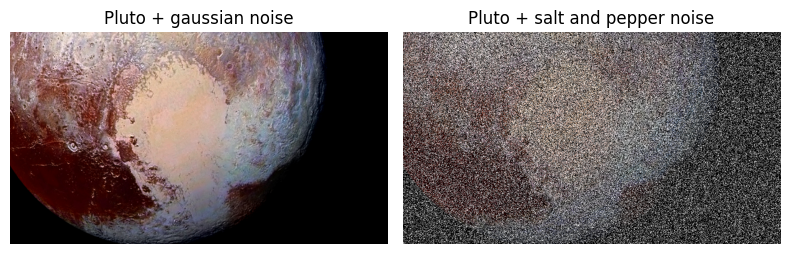

In [56]:
fig = plt.figure(figsize=(8, 5))

gs = gridspec.GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


noisy_pluto = add_salt_and_pepper(CACHE['pluto'].img, amount=1)
noisy_pluto_rgb = cv.cvtColor(noisy_pluto, cv.COLOR_BGR2RGB)


ax1.imshow(CACHE['pluto'].rgb())
ax1.axis('off')
ax1.set_title('Pluto + gaussian noise')

ax2.imshow(noisy_pluto_rgb)
ax2.axis('off')
ax2.set_title('Pluto + salt and pepper noise')

plt.tight_layout()
plt.show()

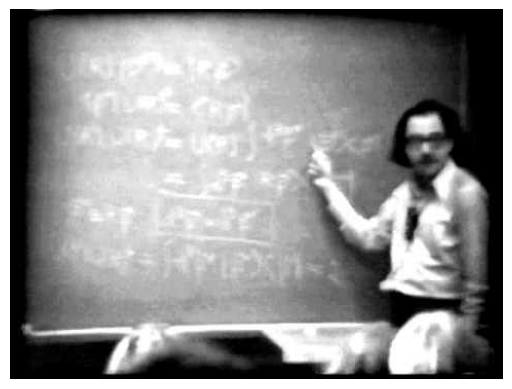

In [59]:
plt.imshow(CACHE['coleman'].rgb())
plt.axis('off')
plt.show()

In [112]:
from scipy import signal

_averaging_filter = np.ones((3, 3)) * (1/9)
_impulse_filter = signal.unit_impulse((3, 3), 'mid')
_impulse_filter[1, 1] = 1.7

_combined_filter = _impulse_filter - _averaging_filter

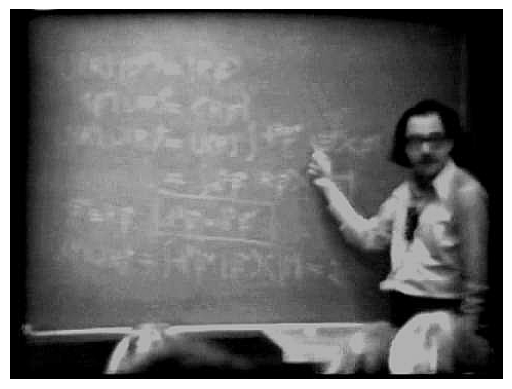

In [113]:
sharpened = cv.filter2D(CACHE['coleman'].img.astype(np.float64), -1, _combined_filter)
sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
sharpened_rgb = cv.cvtColor(sharpened, cv.COLOR_BGR2RGB)

plt.imshow(sharpened_rgb)
plt.axis('off')
plt.show()

In [117]:
coleman_gray = cv.cvtColor(CACHE['coleman'].img, cv.COLOR_BGR2GRAY)

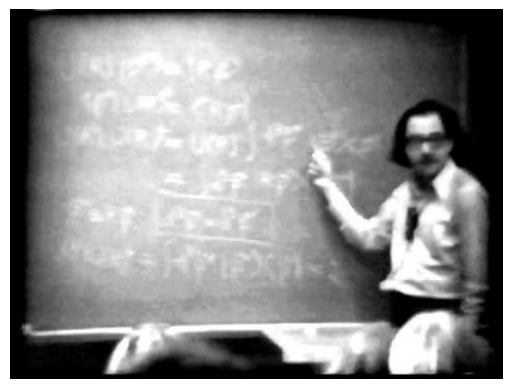

In [123]:
coleman_bilateral = cv.bilateralFilter(coleman_gray, 3, 11, 11)

plt.imshow(coleman_bilateral, cmap='gray')
plt.axis('off')
plt.show()

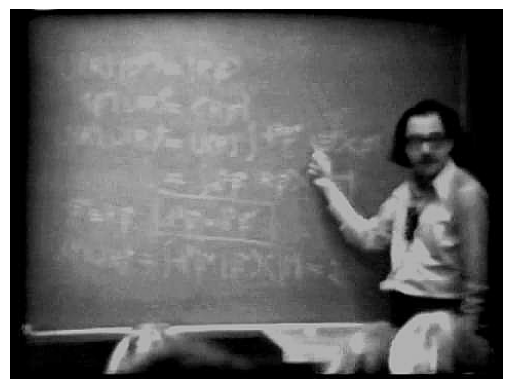

In [125]:
coleman_bilateral = cv.bilateralFilter(sharpened, 3, 11, 11)

plt.imshow(coleman_bilateral, cmap='gray')
plt.axis('off')
plt.show()